In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

In [2]:
veriler = pd.read_csv('maaslar.csv')

## veriler csv dosyasını pickle'a çevirip inceleyeceğim. neden? daha hızlı ve daha managable 

In [3]:
veriler.to_pickle('maaslar.pkl')

In [4]:
data = pd.read_pickle('maaslar.pkl')

In [5]:
data

,unvan,Egitim Seviyesi,maas
0,Cayci,1,2250
1,Sekreter,2,2500
2,Uzman Yardimcisi,3,3000
3,Uzman,4,4000
4,Proje Yoneticisi,5,5500
5,Sef,6,7500
6,Mudur,7,10000
7,Direktor,8,15000
8,C-level,9,25000
9,CEO,10,50000


In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Egitim Seviyesi,10.0,5.5,3.027650,1.0,3.25,5.5,7.75,10.0
maas,10.0,12475.0,14968.694183,2250.0,3250.00,6500.0,13750.00,50000.0


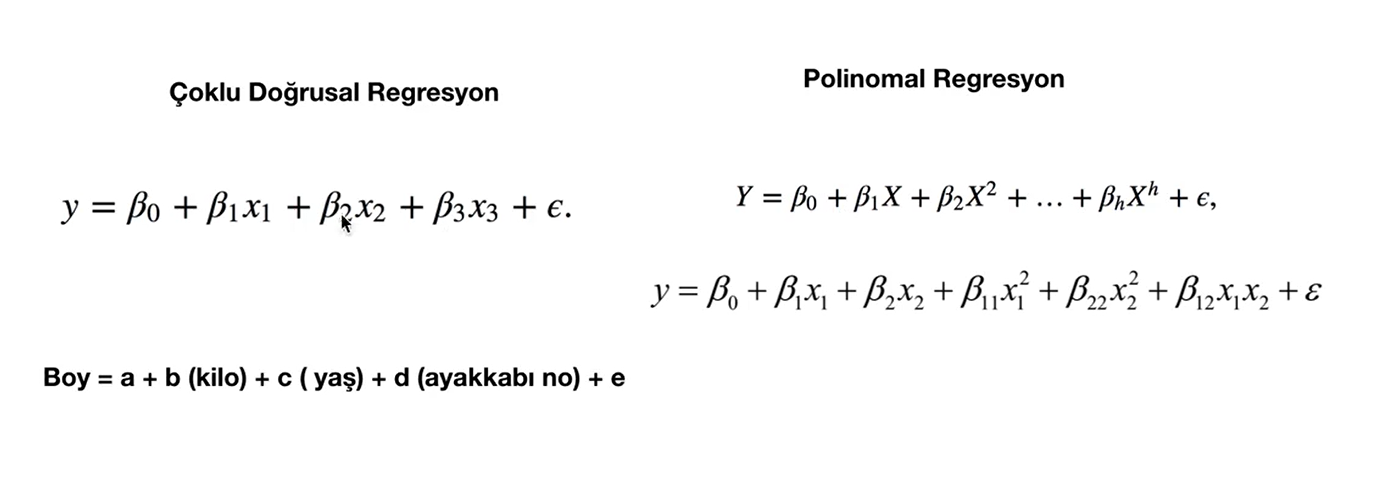

#### gerçekçi olmak gerekirse bu modelde unvan column'u hiç umrumuzda değil. Unvan seviyesi sadece eğitim seviyesi ile alakalı

## null data kontrolü gerçekleştirelim

In [7]:
data.columns[data.isnull().any()] 

Index([], dtype='object')

In [8]:
data.isnull().sum()# yokmuş

unvan              0
Egitim Seviyesi    0
maas               0
dtype: int64

## error düşürmek için modele normalizasyon uygulayarak poly reg. işlemi gerçekleştireceğim

In [9]:
categorical_columns = data.select_dtypes(include = 'object').columns.to_list()
print(categorical_columns)

['unvan']


In [10]:
categorical = categorical_columns

columns_to_normalize = [col for col in data.columns if col not in categorical]
print(columns_to_normalize)

['Egitim Seviyesi', 'maas']


### normalize edeceğimiz iki column var. çok basit biçimde bir polynomial regression kurabiliriz

In [11]:
from sklearn.preprocessing import MinMaxScaler

df_continuous = data[columns_to_normalize]
min_max_columns_names = list(df_continuous.columns)
all_scalers = {}

for column_name in min_max_columns_names:
    scaler = MinMaxScaler()
    scaler.fit(df_continuous[[column_name]])
    all_scalers[column_name] = scaler
    
for column_name, scaler in all_scalers.items():
    df_continuous[column_name] = scaler.transform(df_continuous[[column_name]].values.reshape(-1, 1))


C:\Users\Asus\anaconda3\envs\notebook\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_10232\689206453.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_continuous[column_name] = scaler.transform(df_continuous[[column_name]].values.reshape(-1, 1))
C:\Users\Asus\anaconda3\envs\notebook\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_10232\689206453.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [12]:
normalized_data = pd.concat([df_continuous,data[categorical]], axis= 1)

normalized_data = normalized_data.reindex(data.columns, axis = 1)
normalized_data

,unvan,Egitim Seviyesi,maas
0,Cayci,0.000000,0.000000
1,Sekreter,0.111111,0.005236
2,Uzman Yardimcisi,0.222222,0.015707
3,Uzman,0.333333,0.036649
4,Proje Yoneticisi,0.444444,0.068063
5,Sef,0.555556,0.109948
6,Mudur,0.666667,0.162304
7,Direktor,0.777778,0.267016
8,C-level,0.888889,0.476440
9,CEO,1.000000,1.000000


### veride unvan columnu umrumuzda değil atıyorum

In [13]:
normalized_data = normalized_data.iloc[:, 1:]
normalized_data

,Egitim Seviyesi,maas
0,0.000000,0.000000
1,0.111111,0.005236
2,0.222222,0.015707
3,0.333333,0.036649
4,0.444444,0.068063
5,0.555556,0.109948
6,0.666667,0.162304
7,0.777778,0.267016
8,0.888889,0.476440
9,1.000000,1.000000


### Polynomial Regression modelimizi inşa edelim

In [14]:
x = normalized_data.iloc[:, 0].values.reshape(-1, 1)
x

array([[0.        ],
       [0.11111111],
       [0.22222222],
       [0.33333333],
       [0.44444444],
       [0.55555556],
       [0.66666667],
       [0.77777778],
       [0.88888889],
       [1.        ]])

In [15]:
y = normalized_data.iloc[:,1:].values.reshape(-1, 1)
y

array([[0.        ],
       [0.0052356 ],
       [0.01570681],
       [0.03664921],
       [0.06806283],
       [0.10994764],
       [0.16230366],
       [0.26701571],
       [0.47643979],
       [1.        ]])

###  x eğitim seviyesi, y maaş oldu. Önce linear regression sonra poly reg modelini kuralım

In [16]:
linear_reg = LinearRegression()
linear_reg.fit(x,y)

LinearRegression()

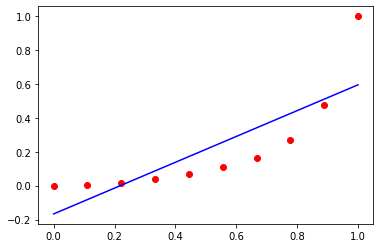

In [17]:
plt.scatter(x,y, color ='red')
plt.plot(x,linear_reg.predict(x), color = 'blue')

### Poly Reg Modeli

In [18]:
poly_reg_2 = PolynomialFeatures(degree = 2)
poly_reg_3 = PolynomialFeatures(degree = 3)
poly_reg_5 = PolynomialFeatures(degree = 5)
poly_reg_13 = PolynomialFeatures(degree = 13)

In [19]:
x_poly_2 = poly_reg_2.fit_transform(x)
print(x_poly_2)

[[1.         0.         0.        ]
 [1.         0.11111111 0.01234568]
 [1.         0.22222222 0.04938272]
 [1.         0.33333333 0.11111111]
 [1.         0.44444444 0.19753086]
 [1.         0.55555556 0.30864198]
 [1.         0.66666667 0.44444444]
 [1.         0.77777778 0.60493827]
 [1.         0.88888889 0.79012346]
 [1.         1.         1.        ]]


In [20]:
reg_2 = LinearRegression()
reg_2.fit(x_poly_2, y)

LinearRegression()

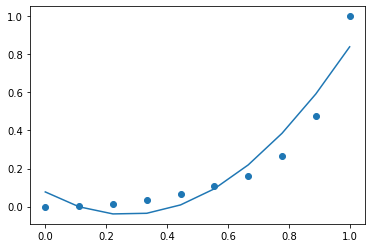

In [21]:
plt.scatter(x,y)
plt.plot(x,reg_2.predict(poly_reg_2.fit_transform(x)))

### 2. dereceden polinomda böyle gözüktü, diğer poly regression modellerini de yazdıralım

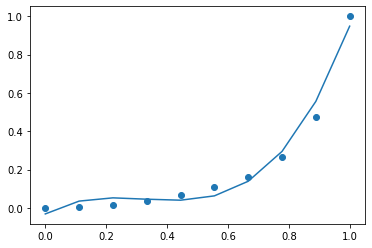

In [22]:
x_poly_3 = poly_reg_3.fit_transform(x)
reg_3 = LinearRegression()
reg_3.fit(x_poly_3, y)

plt.scatter(x,y)
plt.plot(x,reg_3.predict(poly_reg_3.fit_transform(x)))

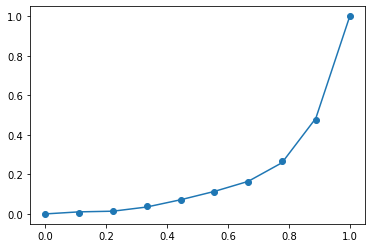

In [23]:
x_poly_5 = poly_reg_5.fit_transform(x)
reg_5 = LinearRegression()
reg_5.fit(x_poly_5, y)

plt.scatter(x,y)
plt.plot(x,reg_5.predict(poly_reg_5.fit_transform(x)))

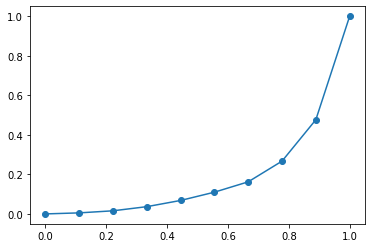

In [24]:
x_poly_13 = poly_reg_13.fit_transform(x)
reg_13 = LinearRegression()
reg_13.fit(x_poly_13, y)

plt.scatter(x,y)
plt.plot(x,reg_13.predict(poly_reg_13.fit_transform(x)))

###  unnormalize edilmiş veri ile ufak bir predict deneyelim

In [29]:
df_continuous = data[columns_to_normalize]
min_max_columns_names = list(df_continuous.columns)
scaling_params = {}

for column_name in min_max_columns_names:
    scaler = MinMaxScaler()
    scaler.fit(df_continuous[[column_name]])
    scaling_params[column_name] = {"min": scaler.data_min_[0], "max": scaler.data_max_[0]}
    df_continuous[column_name] = scaler.transform(df_continuous[[column_name]].values.reshape(-1, 1))
    

predicted_education = x * (scaling_params["Egitim Seviyesi"]["max"] - scaling_params["Egitim Seviyesi"]["min"]) + scaling_params["Egitim Seviyesi"]["min"]
predicted_salary = y * (scaling_params["maas"]["max"] - scaling_params["maas"]["min"]) + scaling_params["maas"]["min"]

C:\Users\Asus\anaconda3\envs\notebook\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_10232\1760866267.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_continuous[column_name] = scaler.transform(df_continuous[[column_name]].values.reshape(-1, 1))
C:\Users\Asus\anaconda3\envs\notebook\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Asus\AppData\Local\Temp\ipykernel_10232\1760866267.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

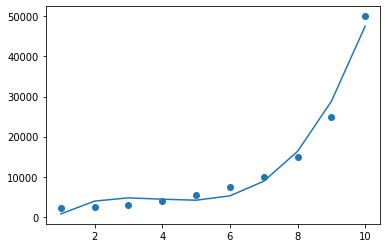

array([[73766.66666667]])

In [30]:
x_poly_3 = poly_reg_3.fit_transform(predicted_education)
reg_3 = LinearRegression()
reg_3.fit(x_poly_3, predicted_salary)

plt.scatter(predicted_education,predicted_salary)
plt.plot(predicted_education,reg_3.predict(poly_reg_3.fit_transform(predicted_education)))
plt.show()

reg_3.predict(poly_reg_3.fit_transform([[11]])) #future prediction değerimiz

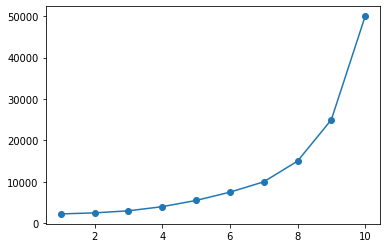

array([[573845.7952279]])

In [31]:
x_poly_13 = poly_reg_13.fit_transform(predicted_education)
reg_13 = LinearRegression()
reg_13.fit(x_poly_13, predicted_salary)

plt.scatter(predicted_education,predicted_salary)
plt.plot(predicted_education,reg_13.predict(poly_reg_13.fit_transform(predicted_education)))
plt.show()

reg_13.predict(poly_reg_13.fit_transform([[11]])) #future prediction değerimiz

### Buradaki işlem bitti, yine de R^2, adjusted R^2, MAE, MAPE, MSE, RMSE üzerindeki erroları inceleyelim

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

X = normalized_data['Egitim Seviyesi']
y = normalized_data['maas']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 42)

In [33]:
x_train, x_test, y_train, y_test = train_test_split(normalized_data, y, train_size = 0.7, test_size = 0.3, random_state = 42)
r2 = reg_13
r2.fit(x_train, y_train)

y_pred = r2.predict(x_test)


In [34]:
# Automating backward elimination technique

def DoBackwardElimination(the_regressor, X, y, minP2eliminate):
    
    assert np.shape(X)[0] == np.shape(y)[0], 'Length of X and y do not match'
    assert minP2eliminate > 0, 'Minimum P value to eliminate cannot be zero or negative'
    
    original_list = list(range(0, np.shape(the_regressor.pvalues)[0]))
    
    max_p = 10        # Initializing with random value of maximum P value
    i = 0
    r2adjusted = []   # Will store R Square adjusted value for each loop
    r2 = []           # Will store R Square value  for each loop
    list_of_originallist = [] # Will store modified index of X at each loop
    classifiers_list = [] # fitted classifiers at each loop
    
    while max_p >= minP2eliminate:
        
        p_values = list(the_regressor.pvalues)
        r2adjusted.append(the_regressor.rsquared_adj)
        r2.append(the_regressor.rsquared)
        list_of_originallist.append(original_list)
        
        max_p = max(p_values)
        max_p_idx = p_values.index(max_p)
        
        if max_p_idx == 0:
            
            temp_p = set(p_values)
            
            # removing the largest element from temp list
            temp_p.remove(max(temp_p))
            
            max_p = max(temp_p)
            max_p_idx = p_values.index(max_p)
            
            print('Index value 0 found!! Next index value is {}'.format(max_p_idx))
            
            if max_p < minP2eliminate:
                
                print('Max P value found less than 0.1 with 0 index ...Loop Ends!!')
                
                break
                
        if max_p < minP2eliminate:
            
            print('Max P value found less than 0.1 without 0 index...Loop Ends!!')
            
            break
        
        val_at_idx = original_list[max_p_idx]
        
        idx_in_org_lst = original_list.index(val_at_idx)
        
        original_list.remove(val_at_idx)
        
        print('Popped column index out of original array is {} with P-Value {}'.format(val_at_idx, np.round(np.array(p_values)[max_p_idx], decimals= 4)))
        
        X_new = X[:, original_list]
        
        the_regressor = sm.OLS(endog = y, exog = X_new).fit()
        classifiers_list.append(the_regressor)
        
        print('==================================================================================================')
        
    return classifiers_list, r2, r2adjusted, list_of_originallist

In [35]:
regressor_SLR_OLS = sm.OLS(endog = y_train, exog = X_train).fit()

# Looking at the summary of regressor
print(regressor_SLR_OLS.summary())


                                 OLS Regression Results                                
Dep. Variable:                   maas   R-squared (uncentered):                   0.698
Model:                            OLS   Adj. R-squared (uncentered):              0.648
Method:                 Least Squares   F-statistic:                              13.86
Date:                Thu, 27 Jul 2023   Prob (F-statistic):                     0.00982
Time:                        20:17:18   Log-Likelihood:                         0.72163
No. Observations:                   7   AIC:                                     0.5567
Df Residuals:                       6   BIC:                                     0.5027
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

C:\Users\Asus\anaconda3\envs\notebook\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [49]:
meanAbErr = metrics.mean_absolute_error(y_test, y_pred)
meanSqErr = metrics.mean_squared_error(y_test, y_pred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
#mape = mean_absolute_percentage_error(y_test, y_pred)

print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)



Mean Absolute Error: 9.627715291671279e-17
Mean Square Error: 1.187080023143992e-32
Root Mean Square Error: 1.0895320202472215e-16
